In [120]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score,\
    f1_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.multiclass import OneVsOneClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [3]:
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

In [4]:
X, y = mnist["data"], mnist["target"]

In [5]:
X.shape, y.shape

((70000, 784), (70000,))

In [31]:
28*28 # each pixel has value from 0(white) to 255(black)

784

((-0.5, 27.5, 27.5, -0.5), 5.0)

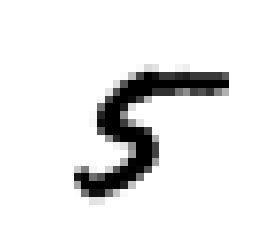

In [70]:
img_number = 33931
some_digit = X[img_number]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off"), y[img_number]

* shuffle indeces and split into 60k and 10k training and test sets

In [30]:
size = 60000
X_train, X_test, y_train, y_test = X[:size], X[size:], y[:size], y[size:]
idx = np.random.permutation(size)

X_train, y_train = X_train[idx], y_train[idx]

* let's just try to identify number 5

In [37]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [38]:
# it's the same shape arrays but with True where there was 5 and False otherwise
y_train_5.shape, y_test_5.shape

((60000,), (10000,))

* a good starting point is Stochastic Gradient Descent (SDG) since it performs well with large datasets

In [44]:
sgd = SGDClassifier(random_state=42, tol=1e-3) # max_iter=5 or tol=1e-3
sgd.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=0.001, verbose=0, warm_start=False)

In [71]:
sgd.predict([some_digit])

array([ True])

### Measuring accuracy using cross-validation

In [48]:
# cv: number of cross-validation folds
cross_val_score(sgd, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9482, 0.9036, 0.9684])

* let's compare it with a dump classifier 5, vs not-5

In [51]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [52]:
never_5 = Never5Classifier()
cross_val_score(never_5, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91215, 0.90745, 0.90935])

* we've got 90% accuracy, that's because roughly 1/10th of all images are 5, so 90% of them are non-5

#### !!! when some classes are more frequent than others, accuracy is NOT a good performance measure !!!

In [56]:
y_train_pred = cross_val_predict(sgd, X_train, y_train_5, cv=3)

In [59]:
# rows - actual class
# cols - predicted class
confusion_matrix(y_train_5, y_train_pred)

array([[51612,  2967],
       [  629,  4792]])

In [61]:
#          TN    FP
#          FN    TP

In [63]:
y_train_perfect_pred = y_train_5
confusion_matrix(y_train_5, y_train_perfect_pred)

array([[54579,     0],
       [    0,  5421]])

### Precision and recall (sensitivity)
* precision (accuracy of positive predictions)
\begin{align}
    precision & = \frac{TP}{TP+FP}
\end{align}
* recall (accuracy of negative predictions)
\begin{align}
    recall & = \frac{TP}{TP+FN}
\end{align}
* $F_{1}$ score (favors classifiers with similar precision and recall)
\begin{align}
    F_{1} & = \frac{2}{\frac{1}{precision}+\frac{1}{recall}}
\end{align}


In [94]:
precision_score(y_train_5, y_train_pred), recall_score(y_train_5, y_train_pred)

(0.6176053615156593, 0.8839697472790998)

In [69]:
f1_score(y_train_5, y_train_pred)

0.7271623672230653

### Precision/recall tradeoff

In [73]:
y_scores = sgd.decision_function([some_digit])
y_scores

array([45348.90962781])

* now let's get y_scores for all instances

In [75]:
y_scores = cross_val_predict(sgd, X_train, y_train_5, cv=3, method="decision_function")

In [77]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

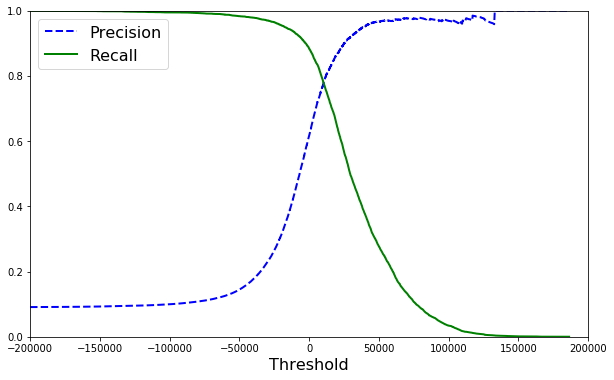

In [82]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(10, 6))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-200000, 200000])
plt.show()

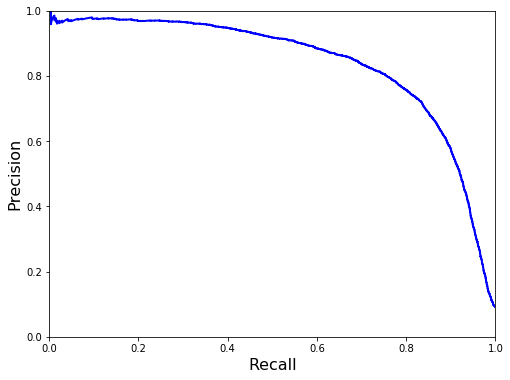

In [84]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

### ROV (receiver operating characteristic) curve

* plot TPR vs FPR (true positive rate vs false positive rate)

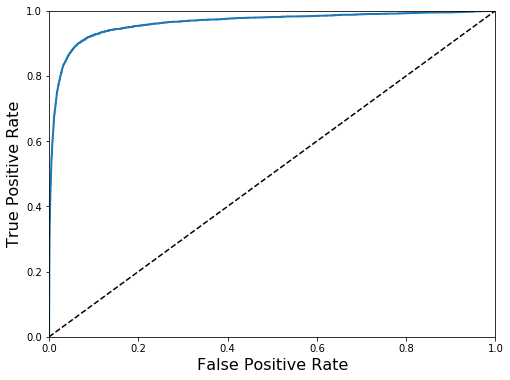

In [86]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [88]:
roc_auc_score(y_train_5, y_scores)

0.96263532324718

### Random forest

In [90]:
forest = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest, X_train, y_train_5, cv=3, method="predict_proba")

In [91]:
y_scores_forest = y_probas_forest[:, 1] # positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

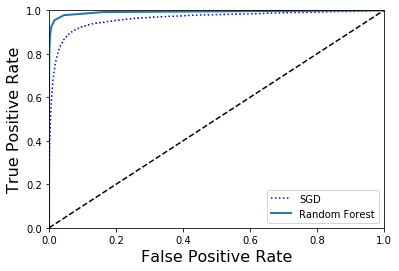

In [92]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [93]:
roc_auc_score(y_train_5, y_scores_forest)

0.9924754884244007

In [97]:
y_train_pred_forest = cross_val_predict(forest, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest), recall_score(y_train_5, y_train_pred_forest)

(0.9859216893972723, 0.8267847260653016)

### Multiclass classification

* when feeded with multiple classes data, the SGDClassifier creates N-binary classfiers (using one-versus-all strategy) and predicts based on the highest score

In [99]:
sgd.fit(X_train, y_train) # we train against whole dataset, not only 5's
sgd.predict([some_digit])

array([5.])

* let's see the scores for this image from each classifier

In [101]:
sgd.decision_function([some_digit])

array([[ -58444.80262624, -141179.68635179, -100349.04941932,
         -62832.80757996,  -93309.3728018 ,   45348.90962781,
        -108778.43501821,  -58112.76460014,  -14988.68578001,
         -44894.86682679]])

In [104]:
sgd.decision_function([some_digit])[:,5]

array([45348.90962781])

In [105]:
sgd.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

* we can force to use OneVsOne or OneVsRest explicitely

In [108]:
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42, tol=1e-3))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5.])

In [110]:
len(ovo_clf.estimators_) # N(N-1)/2

45

* random forest also supports multiclass data

In [111]:
forest.fit(X_train, y_train) # we are training across all digits
forest.predict([some_digit])

array([5.])

In [112]:
forest.predict_proba([some_digit])

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

* let's evaluate now sgd classifier with 10 classes

In [123]:
cross_val_score(sgd, X_train, y_train, cv=3, scoring="accuracy")

array([0.86032793, 0.84624231, 0.87913187])

In [124]:
cross_val_score(never_5, X_train, y_train, cv=3, scoring="accuracy") # random classifier gets on average 10% as expected

array([0.10185, 0.09905, 0.09525])

* now we can improve 85% score by scaling data from 0-255 range to ?-? range

In [121]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [130]:
X_train_scaled.min(), X_train_scaled.max() 

(-1.2742078920822273, 244.94693302871053)

In [131]:
cross_val_score(sgd, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.90396921, 0.90264513, 0.90203531])

In [132]:
y_train_pred = cross_val_predict(sgd, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5600,    0,   19,    7,    8,   47,   36,    6,  199,    1],
       [   1, 6427,   42,   22,    3,   39,    4,    8,  183,   13],
       [  33,   28, 5241,   90,   64,   23,   70,   41,  358,   10],
       [  27,   24,  106, 5251,    1,  225,   23,   44,  362,   68],
       [  15,   15,   39,   10, 5234,   10,   38,   17,  301,  163],
       [  32,   17,   27,  160,   51, 4526,   71,   15,  452,   70],
       [  26,   18,   48,    2,   41,   98, 5550,    8,  127,    0],
       [  19,   15,   54,   27,   49,   14,    6, 5723,  155,  203],
       [  16,   61,   42,   90,    2,  118,   29,    7, 5438,   48],
       [  25,   24,   26,   56,  122,   39,    1,  168,  305, 5183]])